In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Define constants exmple 6.2 from book sutton and barto chapter 6 (Random Walk)
# A Markov reward process, or MRP, is a Markov decision process without actions.

# We will often use MRPs when focusing on the prediction problem, in which there 
# is no need to distinguish the dynamics due to the environment from those due to 
# the agent. In this MRP, all episodes start in the center state, C, then proceed 
# either left or right by one state on each step, with equal probability.

GO_LEFT = 0
GO_RIGHT = 1

# Given The true values of all the states, A through E, are 1/6,2/6,3/6,4/6,and 5/6.
# create true value function
TRUE_VALUES = np.arange(6) / 6.0
TRUE_VALUES = np.append(TRUE_VALUES, 1)

# Given in all cases the approximate value function was initialized to the intermediate 
# value V (s) = 0.5, for all s. 
# create value value function
V = np.zeros(6)
V[1:6] = 0.5
V = np.append(V, 1)

print('True Values: {}'.format(TRUE_VALUES))
print('Current Values: {}'.format(V))

True Values: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
Current Values: [0.  0.5 0.5 0.5 0.5 0.5 1. ]


In [16]:
def prediction(method, current_values, alpha=0.1, batch_updating=False):
    # all episode start from the state C
    current_state = 3
    process = [current_state]
    
    if method=='TD':
        process_rewards = [0]
        while True:
            # sampling based on binomial distribution
            # https://docs.scipy.org/doc/numpy/reference/random/generated/numpy.random.Generator.binomial.html#numpy.random.Generator.binomial
            # sample next action
            action = np.random.binomial(n=1, p=0.5)
            if action == GO_LEFT:
                next_state = current_state - 1
            else:
                next_state = current_state + 1

            # as complete return is not calculated in TD 
            # we can assume all rewards are 0
            immediate_reward = 0

            # update values if not batch updating
            if not batch_updating:
                td_err = immediate_reward + current_values[next_state] - current_values[current_state]
                current_values[current_state] += alpha * td_err

            process.append(next_state)
            if next_state == 0 or next_state == 6:
                break

            process_rewards.append(immediate_reward)
            current_state = next_state
        return process, process_rewards
    else:
        while True:
            action = np.random.binomial(n=1, p=0.5)
            if action==GO_LEFT:
                next_state = current_state - 1
            else:
                next_state = current_state + 1
            process.append(next_state)
            
            # returns are 0 and 1 if agent ends up in 
            # left and right terminal states respectively
            if next_state == 6:
                returns = 1.0
                break
            if next_state == 0:
                returns = 0.0
                break
            current_state = next_state
        # get returns for each intermediate state
        t_returns = [returns] * (len(process) - 1)
        if not batch_updating:
            for state in process[:-1]:
                error = returns - current_values[state]
                current_values[state] += alpha * error
        return process, t_returns

In [17]:
# plot values learned after various numbers of episodes on a single run of TD(0)
def plot_state_values():
    episodes = [0, 1, 10, 100]
    plt.figure(1)
    current_values = np.copy(V)
    for i in range(101):
        if i in episodes:
            # plot graph
            plt.plot(current_values, label=str(i))
        prediction('TD', current_values)
    plt.plot(TRUE_VALUES, label='true values')
    plt.xlabel('State')
    plt.ylabel('Estimated State Values')
    plt.legend(loc="upper left")

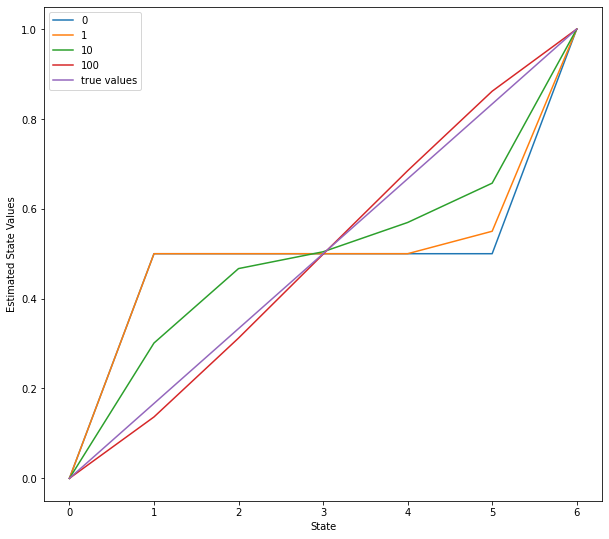

In [18]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
plot_state_values()

In [25]:
def get_rms_error():
    # define alpha values as defined in the example
    mc_alpha = [0.01, 0.02, 0.03, 0.04]
    td_alpha = [0.05, 0.1, 0.15]
    
    # max_iterations
    max_iterations = 100
    
    # total episodes
    episodes = 101
    
    all_alphas = mc_alpha + td_alpha
    
    for i, alpha in enumerate(all_alphas):
        all_errors = np.zeros(episodes)
        if i < len(mc_alpha):
            method = 'MC'
            plotstyle = 'dashdot'
        else:
            method='TD'
            plotstyle='solid'
        for iteration in range(max_iterations):
            current_values = np.copy(V)
            errors = list()
            for eps in range(episodes):
                rms = np.sqrt(np.sum(np.power(TRUE_VALUES - current_values, 2)) / 5.0)
                errors.append(rms)
                if method=='MC':
                    prediction(method, current_values, alpha=alpha)
                else:
                    prediction(method, current_values, alpha=alpha)
            all_errors+=np.asarray(errors)
        all_errors /= max_iterations
        plt.plot(all_errors, linestyle=plotstyle, label=method + ', alpha = %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS error')
    plt.legend()

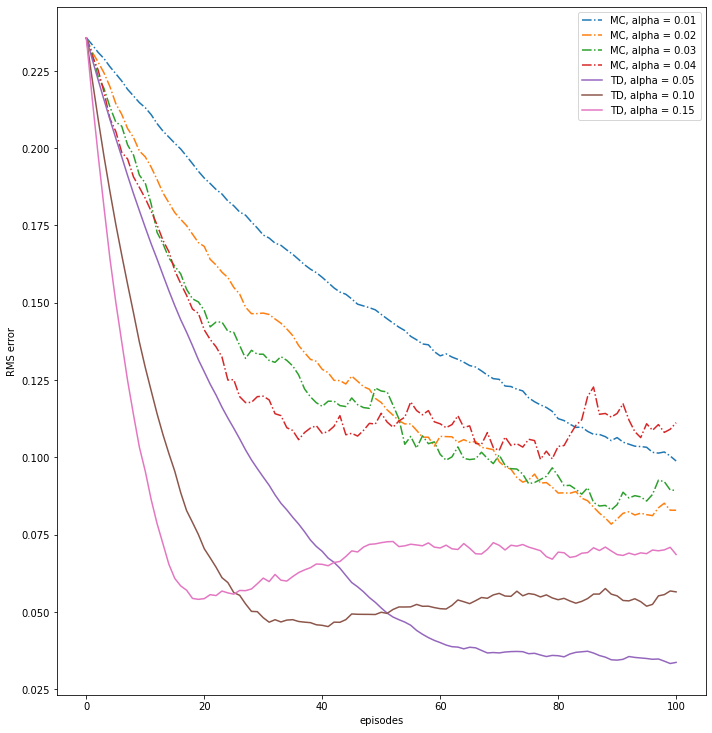

In [26]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 2)
get_rms_error()
plt.tight_layout()


In [33]:
def batch_predction(method, episodes, alpha=0.001):
    # maximum no of iterations to run for batch updating
    max_iterations = 100
    all_err = np.zeros(episodes)
    for i in range(max_iterations):
        current_values = np.copy(V)
        errors = list()
        processes = list()
        all_rewards = list()
        for eps in range(episodes):
            process, rewards = prediction(method, current_values, alpha=alpha)
            processes.append(process)
            all_rewards.append(rewards)
            # loop until convergence of value function
            while True:
                increments = np.zeros(7)
                for process, rewards in zip(processes, all_rewards):
                    for i in range(0, len(process) - 1):
                        # update according to method
                        if method == 'MC':
                            increments[process[i]] += rewards[i] - current_values[process[i]]
                        else:
                            increments[process[i]] += rewards[i] + current_values[process[i+1]] - current_values[process[i]]
                
                increments *= alpha
                
                if np.sum(np.abs(increments)) < 1e-3:
                    break
                
                # update values
                current_values += increments
                
            # get rms erros
            err = np.sqrt(np.sum(np.power(TRUE_VALUES - current_values, 2)) / 5.0)
            errors.append(err)
        all_err += np.asarray(errors)
    return all_err / max_iterations

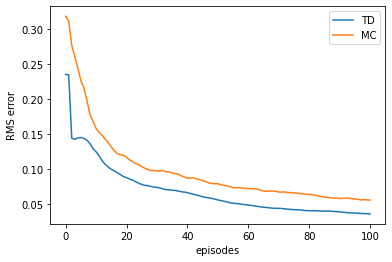

In [34]:
episodes = 100 + 1
td_erros = batch_predction('TD', episodes)
mc_erros = batch_predction('MC', episodes)
plt.plot(td_erros, label='TD')
plt.plot(mc_erros, label='MC')
plt.xlabel('episodes')
   
plt.ylabel('RMS error')   
plt.legend()